## **Regression by pycaret**

pycaretによるbostonデータセットの回帰実行サンプル  

参考にしたURL  
【公式】 Regression  
https://pycaret.readthedocs.io/en/latest/api/regression.html  

Setting up Environment  
https://pycaret.org/setup/  

pycaret/examples/  
https://github.com/pycaret/pycaret/tree/master/examples  

#### **Google Colaboratoyの環境確認/設定**

In [1]:
# Linuxの環境確認
!cat /etc/issue   # OSバージョン
!uname -a         # 〃
!cat /proc/cpuinfo | grep 'model name'                                   # CPU
!cat /proc/meminfo | grep Mem | awk '{print $1 " " $2/1024/1024 " GB"}'  # メモリ
!df -h | grep -v -e tmp -e shm                                           # ファイルシステム
!cat /proc/uptime  | awk '{print $1/60/60 " hours (" $1 "sec)"}'         # uptime
!nvidia-smi                                                              # GPU

# pycaret関連のインストール
! pip install -U pycaret[full]

Ubuntu 18.04.5 LTS \n \l

Linux 1610462b445d 5.4.104+ #1 SMP Sat Jun 5 09:50:34 PDT 2021 x86_64 x86_64 x86_64 GNU/Linux
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
MemTotal: 12.6867 GB
MemFree: 4.09676 GB
MemAvailable: 11.8511 GB
Filesystem      Size  Used Avail Use% Mounted on
overlay         148G   39G  109G  27% /
/dev/sda1       154G   42G  112G  28% /opt/bin/.nvidia
4.43858 hours (15978.89sec)
Wed Aug 25 06:47:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+=========

### **ライブラリの読み込み**

In [2]:
import sys
print(sys.version)   # 3.7.11 (default, Jul  3 2021, 18:01:19) 
import math
import random
import copy
import os
import statistics as stat
from pprint   import pprint
from datetime import datetime, timedelta, timezone
JST = timezone(timedelta(hours=+9), 'JST')
print(f'now: {datetime.now(JST):"%F %T)}') 

import numpy  as np
import pandas as pd
# pandas表示設定値の変更
pd.set_option('display.width',      100)
pd.set_option('display.precision',    4)
pd.set_option('display.max_rows',    20)
pd.set_option('display.max_columns', 12)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew #for some statistics

import sklearn 
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
# metrics for Classificaqtion
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# metrics for  regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import pycaret
from pycaret.regression import * ####  regressionモジュールをインポート

import xgboost
import lightgbm
import catboost
import optuna


#バージョン確認
print(f'Module\'s Version; ',
      f'pycaret: {pycaret.__version__}, sklearn: {sklearn.__version__},',
      f'xgboost: {xgboost.__version__}, lightgbm: {lightgbm.__version__},',
      f'catboost: {catboost.__version__}, optuna: {optuna.__version__}'
      )

3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
now: "2021-08-25 15:47:43)
Module's Version;  pycaret: 2.3.3, sklearn: 0.23.2, xgboost: 1.4.2, lightgbm: 3.2.1, catboost: 0.26.1, optuna: 2.9.1


#### **関数定義**

In [3]:
### Functions =================================================================
def xdescribe(df, dsp=True, ret=False):   # pandas.describeメソッドの拡張 

    print(f'## Shape:{df.shape}')
    dtype    = pd.DataFrame({'dtype' : df.dtypes        })
    n_na     = pd.DataFrame({'NAs'   : df.isnull().sum()})
    n_unique = pd.DataFrame({'n_unique': [len(df[c].unique()) for c in df.columns]},
                            index=df.columns)
    df_descr = df.describe(include='all').T
    if 'unique' in df_descr.columns:
        df_descr = df_descr.drop(['unique'], axis=1)
    df_descr = pd.concat([dtype, n_na, n_unique, df_descr], axis=1)
    df_descr['count'] = df_descr['count'].astype(int)

    if dsp:
        # backup & restore pandas display sttting
        mr = pd.get_option('display.max_rows')  # backup sttting
        pd.set_option('display.max_rows', None) # unlimitted
        display(df_descr)
        pd.set_option('display.max_rows', mr)   # restore sttting

        # Category Features: Print Elements
        prt = True
        for idx in df_descr.index:
            if df_descr['dtype'].astype(str)[idx] == 'category':
                if prt:
                    print(f'### Featur: Categories')
                    prt = False 
                print(f' {idx}: \t{df[idx].cat.categories}')

    if ret:
        return df_descr
    else:
        return

### Functions =================================================================
# 変数の分布を確認
def target_dist(df, target_colname):
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df[target_colname])
    skewness    = skew(df[target_colname].dropna())
    print( f'\n 平均 = {mu:.2f}, 分散 = {sigma:.2f}, 歪度 = {skewness:.2f}')

    # plot the distribution
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title(target_colname+' distribution')
    sns.distplot(df[target_colname], fit=norm)

    # Q-Q plot
    ax = fig.add_subplot(1, 2, 2)
    stats.probplot(df[target_colname], plot=plt) 
    plt.show()

### **データの取得・確認**

#### **pycaretに含まれているbostonデータを使用**

各変数の属性の確認  
目的変数の分布を確認


## Shape:(506, 14)


,dtype,NAs,n_unique,count,mean,std,min,25%,50%,75%,max
CRIM,float64,0,504,506,3.6135,8.6015,0.0063,0.0820,0.2565,3.6771,88.9762
ZN,float64,0,26,506,11.3636,23.3225,0.0000,0.0000,0.0000,12.5000,100.0000
INDUS,float64,0,76,506,11.1368,6.8604,0.4600,5.1900,9.6900,18.1000,27.7400
CHAS,float64,0,2,506,0.0692,0.2540,0.0000,0.0000,0.0000,0.0000,1.0000
NOX,float64,0,81,506,0.5547,0.1159,0.3850,0.4490,0.5380,0.6240,0.8710
RM,float64,0,446,506,6.2846,0.7026,3.5610,5.8855,6.2085,6.6235,8.7800
AGE,float64,0,356,506,68.5749,28.1489,2.9000,45.0250,77.5000,94.0750,100.0000
DIS,float64,0,412,506,3.7950,2.1057,1.1296,2.1002,3.2074,5.1884,12.1265
RAD,float64,0,9,506,9.5494,8.7073,1.0000,4.0000,5.0000,24.0000,24.0000
TAX,float64,0,66,506,408.2372,168.5371,187.0000,279.0000,330.0000,666.0000,711.0000


Shapes: train:(404, 14), test:(102, 14)

## 目的変数の分布を確認

 平均 = 22.61, 分散 = 9.23, 歪度 = 1.02


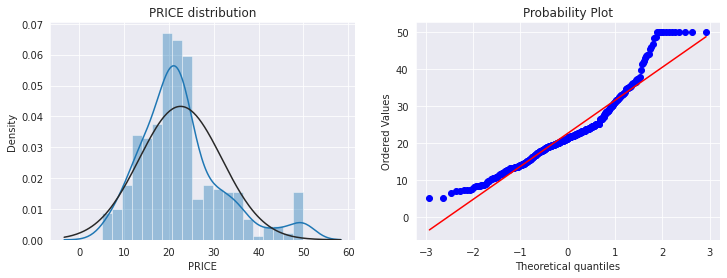

In [4]:
#ボストン住宅価格データセットの読み込み
from sklearn.datasets import load_boston
boston = load_boston()
# データフレームの作成
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['PRICE'] = np.array(boston.target)
xdescribe(df)

target_colname = 'PRICE'          # 目的変数を指定
target_metric  = 'R2'             # 評価項目を指定
target_metric_ascending = False   # 評価項目のソート順

# データセットの分割 (学習用と学習結果の評価用)
df_train, df_test = train_test_split(df, train_size=0.8, random_state=0, shuffle=True)
print(f'Shapes: train:{df_train.shape}, test:{df_test.shape}')

print(f'\n## 目的変数の分布を確認') 
target_dist(df_train, target_colname)

### **データセット、学習に関する設定 (setup)**

参考にしたURL  
PyCaretのsetup関数の引数について  
https://qiita.com/Asagumo63/items/99357d4b472a9219040e  
PyCaretでできる前処理について調べてみた  
https://qiita.com/tomiyou/items/e1842775e7aaee04ada3


In [5]:
exp1 = setup(
    # データセット関連
    df_train,                     # 学習対象のデータセット
    target = target_colname,      # 目的変数名
    ignore_features = None,       # 学習に使用しない列名
    categorical_features = None,  # カテゴリ変数名のリスト           (str, default=None)
    ordinal_features     = None,  # 順序変数名と順序リストの辞書 ({col:[lv1,lv2,..])

    # 特徴量エンジニアリング関連
    remove_outliers             = False, # 外れ値削除                 (bool,  default=False)
    outliers_threshold          = 0.05,  # 外れ値削除の閾値           (float, default=0.05)
    remove_multicollinearity    = False, # 共線性の高い列の削除       (bool,  default=False)
    multicollinearity_threshold = 0.9,   # 共線性の高い列の削除の閾値 (float, default=0.9)
    feature_selection           = False, # 特徴量選択                 (bool,  default=False)
    feature_selection_threshold = 0.8,   # 特徴量選択の閾値           (float, default=0.8)
    normalize                   = False, # 正規化                     (bool, default = False)
    normalize_method            = 'zscore', # 正規化メッソド[zscore,minmax,robust] (str, default='zscore')
    transformation              = False, # 説明変数の対数変換          (bool, default = False)
    transformation_method       = 'yeo-johnson', # 説明変数の対数変換メソッド (str, default='yeo-johnson'
    transform_target            = False, # 目的変数の対数変換         (bool,  default=False)

    # 学習環境関連
    train_size = 0.8,         # 学習で使うデータの割合。残りは評価で使用
    fold = 10,                # CVのfold数                            (int,   defaut=10)
    fold_strategy = 'kfold',  # default='kfold', or 'stratifiedkfold'
    fold_shuffle = True,      # 

    # 実行環境関連
    session_id = 0,           # random seed
    n_jobs = -1,              # 同時実行job数、-1ですべてのプロセッサを使用
    use_gpu = True,           # GPUを使用
    silent = True,            # 項目属性の自動判別結果の確認を抑制
)

,Description,Value
0,session_id,0
1,Target,PRICE
2,Original Data,"(404, 14)"
3,Missing Values,False
4,Numeric Features,12
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(323, 13)"


### **ベースモデルの性能比較 (compare_models)**


利用可能なすべてのモデルで学習し、結果を比較

In [6]:
n_top = 8 
top_models = compare_models( 
    sort = target_metric, 
    n_select = n_top,    # 上位8モデルをreturn
    verbose = False
)
compare_models_score = pull() # 学習結果の取得
print(f'\n## ベースモデルの学習結果 (metric:{target_metric})')
display(compare_models_score)
top_models = top_models[0:n_top] # 後の学習で利用するため、各モデルの上位8モデルを保存

# 結果集約用データフレームの作成
col_names = ['Desc'] + compare_models_score.columns.values.tolist()
all_model_score = compare_models_score[0:n_top]
all_model_score['Desc']  = 'Base'
all_model_score['Model'] = all_model_score.index
all_model_score = all_model_score.reindex(columns=col_names).reset_index(drop=True)
#display(all_model_score)


## ベースモデルの学習結果 (metric:R2)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1.9093,7.5573,2.6672,0.9039,0.1207,0.0974,0.672
catboost,CatBoost Regressor,1.9639,8.2283,2.7698,0.9003,0.1234,0.0980,1.744
gbr,Gradient Boosting Regressor,2.2445,10.1971,3.0698,0.8731,0.1407,0.1155,0.091
xgboost,Extreme Gradient Boosting,2.3078,10.3421,3.1214,0.8682,0.1367,0.1128,0.547
rf,Random Forest Regressor,2.2658,10.8182,3.1867,0.8661,0.1405,0.1136,0.716
lightgbm,Light Gradient Boosting Machine,2.2937,10.9628,3.2544,0.8623,0.1407,0.1128,0.033
ada,AdaBoost Regressor,2.4851,10.8665,3.2304,0.8590,0.1537,0.1304,0.091
lr,Linear Regression,3.2274,22.4295,4.5675,0.7442,0.2339,0.1551,0.007
ridge,Ridge Regression,3.2210,22.6327,4.5712,0.7435,0.2267,0.1554,0.006
br,Bayesian Ridge,3.2655,23.0694,4.6230,0.7376,0.2268,0.1570,0.007


### **モデルの選定、ハイパーパラメータチューニング**

チューニングの探索方式(ライブラリ+アルゴリズム)、探索回数を指定する。  
ここではOptunaのTPEを利用、探索回数を300と指定してそれぞれをチューニングしたところ、R2値が改善された。  

In [7]:
# 上位8モデルのハイパーパラメータチューニングを実施
n_fold =  10 # cvのfold数: 指定しなければsetup()で指定した値(デフォルト:10)が使われる

# ハイパーパラメータチューニングの探索方式・回数を設定
search_library   = 'optuna' # 'scikit-learn'(default) | 'scikit-optimize' | 'optuna' 
search_algorithm = 'tpe'    # 'random'|'grid'         | 'bayesian'        | 'random'|'tpe'
n_iter = 300 # ハイパーパラメータの探索回数

tuned_models = []
for i, model in enumerate(top_models):
    model_name = all_model_score.loc[i,"Model"]
    time_start = datetime.now(JST)
    print(f'\n## {i+1}/{len(top_models)} Model Name: {model_name}, Tune-n_iter:{n_iter},',
          f' start time:{time_start:%F %T}')
    tuned_model = tune_model(
        model, 
        fold    = n_fold, 
        n_iter  = n_iter, 
        search_library   = search_library, 
        search_algorithm = search_algorithm,
        early_stopping   = True,
        optimize = target_metric, 
        verbose = False
    )
    elapse = (datetime.now(JST)-time_start).total_seconds()
    tuned_models.append(tuned_model)
    model_score = pull()['Mean':'Mean']
    display(model_score)
    
    model_score = pd.concat([pd.Series({'Desc': 'Tuned_iter'+str(n_iter), 'Model': model_name}), 
                             model_score.iloc[0],
                             pd.Series({'Elapse': elapse}),
                            ])
    #display(model_score)
    all_model_score = all_model_score.append(model_score, ignore_index=True)

print(f'\n## これまでのモデルの学習結果 (metric:{target_metric})')
display(all_model_score.sort_values(target_metric, ascending=target_metric_ascending))


## 1/8 Model Name: et, Tune-n_iter:300,  start time:2021-08-25 15:48:34


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,1.936,7.2976,2.6378,0.9072,0.1206,0.0985



## 2/8 Model Name: catboost, Tune-n_iter:300,  start time:2021-08-25 16:42:44


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already speci

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,1.9085,7.3919,2.6324,0.9097,0.1204,0.0959



## 3/8 Model Name: gbr, Tune-n_iter:300,  start time:2021-08-25 17:38:38


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,2.0195,7.5154,2.6721,0.9064,0.1263,0.1028



## 4/8 Model Name: xgboost, Tune-n_iter:300,  start time:2021-08-25 17:47:12


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,2.0226,8.2851,2.7908,0.8941,0.1242,0.1011



## 5/8 Model Name: rf, Tune-n_iter:300,  start time:2021-08-25 18:46:06


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,2.1624,9.7725,3.0084,0.8832,0.1346,0.1096


ストリーミング出力は最後の 5000 行に切り捨てられました。
[LightGBM] [Warning] bagging_fraction is set=0.8179344541655483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8179344541655483
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9931160550453296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9931160550453296
[LightGBM] [Warning] bagging_fraction is set=0.8179344541655483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8179344541655483
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9164644661268372, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9164644661268372
[LightGBM] [Warning] bagging_fraction is set=0.8453650892166245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8453650892166245
[Li

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,2.0377,8.6856,2.8461,0.8905,0.1298,0.1052



## 7/8 Model Name: ada, Tune-n_iter:300,  start time:2021-08-25 19:58:11


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,2.4193,10.4087,3.1328,0.8632,0.1513,0.128



## 8/8 Model Name: lr, Tune-n_iter:300,  start time:2021-08-25 20:19:25


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,3.2274,22.4295,4.5675,0.7442,0.2339,0.1551



## これまでのモデルの学習結果 (metric:R2)


,Desc,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),Elapse
9,Tuned_iter300,catboost,1.9085,7.3919,2.6324,0.9097,0.1204,0.0959,NaN,3354.0284
8,Tuned_iter300,et,1.9360,7.2976,2.6378,0.9072,0.1206,0.0985,NaN,3249.4244
10,Tuned_iter300,gbr,2.0195,7.5154,2.6721,0.9064,0.1263,0.1028,NaN,514.4731
0,Base,et,1.9093,7.5573,2.6672,0.9039,0.1207,0.0974,0.672,NaN
1,Base,catboost,1.9639,8.2283,2.7698,0.9003,0.1234,0.0980,1.744,NaN
11,Tuned_iter300,xgboost,2.0226,8.2851,2.7908,0.8941,0.1242,0.1011,NaN,3533.6393
13,Tuned_iter300,lightgbm,2.0377,8.6856,2.8461,0.8905,0.1298,0.1052,NaN,455.0018
12,Tuned_iter300,rf,2.1624,9.7725,3.0084,0.8832,0.1346,0.1096,NaN,3869.6992
2,Base,gbr,2.2445,10.1971,3.0698,0.8731,0.1407,0.1155,0.091,NaN
3,Base,xgboost,2.3078,10.3421,3.1214,0.8682,0.1367,0.1128,0.547,NaN


### **モデル分析・評価 (evaluate models)**

**参考にしたURL**  
Pycaretの回帰・分類で出力されるグラフの種類について解説　　
https://qiita.com/ground0state/items/57e565b23770e5a323e9

In [8]:
tuned_model = tuned_models[0] # ベースモデル比較での最上位モデルを選択してモデル評価

In [9]:
# 学習結果の確認
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

#### **個別にプロットする場合 (plot_model)**

個別にプロットしたい場合には、plot_model関数を使用

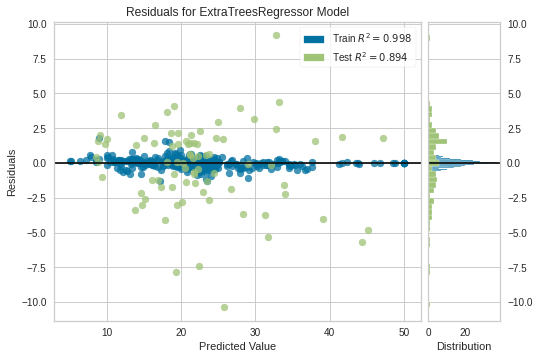

In [10]:
plot_model(tuned_model, plot='residuals') # 残差プロット

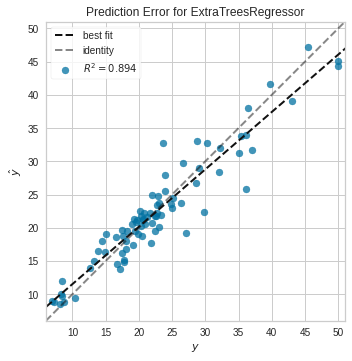

In [11]:
plot_model(tuned_model, plot='error') # 予測誤差(true-pred)プロット

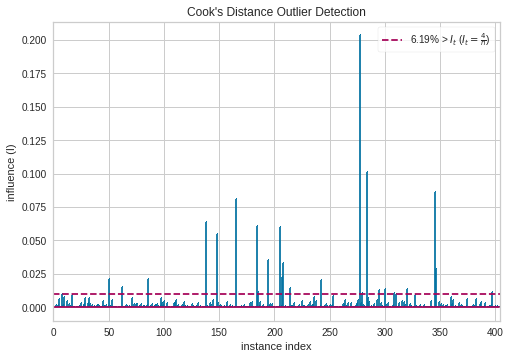

In [12]:
plot_model(tuned_model, plot='cooks') # クックの距離

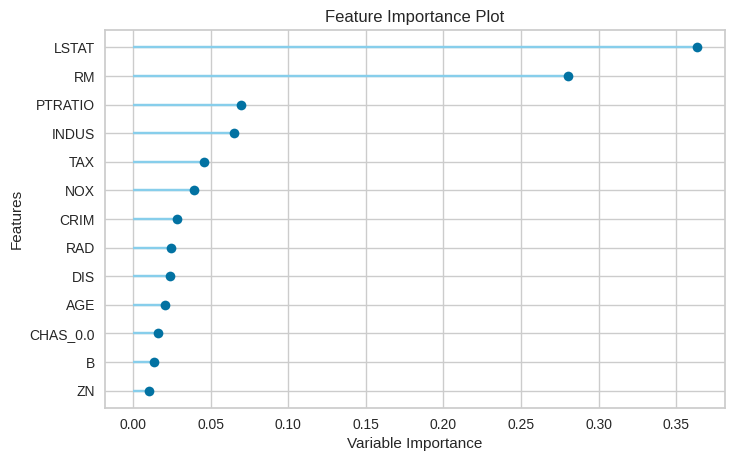

In [13]:
plot_model(tuned_model, plot='feature_all') # 特徴量の重要度

### **モデルのファイナライズ (finalize_model)、予測 (predict_model)**

モデルをファイナライズし、最初に分離したテストデータセットに対して予測を実施  


In [14]:
final_tuned_models = []
all_final_model_score = pd.DataFrame()
for i, tuned_model in enumerate(tuned_models):
    model_name = all_model_score.loc[i,"Model"]
    print(f'\n### Model Name: {model_name}')
    final_model = finalize_model(tuned_model)
    #print(final_model)
    final_tuned_models.append(final_model)

    pred_test = predict_model(final_model, data=df_test)
    #display(pred_test)
    r2   = r2_score(df_test[target_colname], pred_test["Label"])
    rmse = math.sqrt(mean_absolute_error(df_test[target_colname], pred_test["Label"]))
    print(f'\n### Model Name: {model_name}, Score R2: {r2:.5f}, RMSE: {rmse:.5f}\n')
    
    model_score = pd.Series({'Desc': 'Final_Tuned', 'Model': model_name, 'RMSE': rmse, 'R2': r2})
    all_final_model_score = all_final_model_score.append(model_score, ignore_index=True)

print(f'\n### 最初に分離したテストデータに対する予測結果 (metric:{target_metric})')
display(all_model_score.sort_values(target_metric, ascending=target_metric_ascending))
display(all_final_model_score.sort_values(target_metric, ascending=target_metric_ascending))


### Model Name: et

### Model Name: et, Score R2: 0.73591, RMSE: 1.65792


### Model Name: catboost

### Model Name: catboost, Score R2: 0.72551, RMSE: 1.64013


### Model Name: gbr

### Model Name: gbr, Score R2: 0.74063, RMSE: 1.63362


### Model Name: xgboost

### Model Name: xgboost, Score R2: 0.73214, RMSE: 1.64576


### Model Name: rf

### Model Name: rf, Score R2: 0.70708, RMSE: 1.68504


### Model Name: lightgbm
[LightGBM] [Warning] feature_fraction is set=0.8288213066258465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8288213066258465
[LightGBM] [Warning] bagging_fraction is set=0.42865865300475053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42865865300475053
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8288213066258465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8288213066258465
[LightGBM]

,Desc,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),Elapse
9,Tuned_iter300,catboost,1.9085,7.3919,2.6324,0.9097,0.1204,0.0959,NaN,3354.0284
8,Tuned_iter300,et,1.9360,7.2976,2.6378,0.9072,0.1206,0.0985,NaN,3249.4244
10,Tuned_iter300,gbr,2.0195,7.5154,2.6721,0.9064,0.1263,0.1028,NaN,514.4731
0,Base,et,1.9093,7.5573,2.6672,0.9039,0.1207,0.0974,0.672,NaN
1,Base,catboost,1.9639,8.2283,2.7698,0.9003,0.1234,0.0980,1.744,NaN
11,Tuned_iter300,xgboost,2.0226,8.2851,2.7908,0.8941,0.1242,0.1011,NaN,3533.6393
13,Tuned_iter300,lightgbm,2.0377,8.6856,2.8461,0.8905,0.1298,0.1052,NaN,455.0018
12,Tuned_iter300,rf,2.1624,9.7725,3.0084,0.8832,0.1346,0.1096,NaN,3869.6992
2,Base,gbr,2.2445,10.1971,3.0698,0.8731,0.1407,0.1155,0.091,NaN
3,Base,xgboost,2.3078,10.3421,3.1214,0.8682,0.1367,0.1128,0.547,NaN


In [15]:
final_model = final_tuned_models[0]

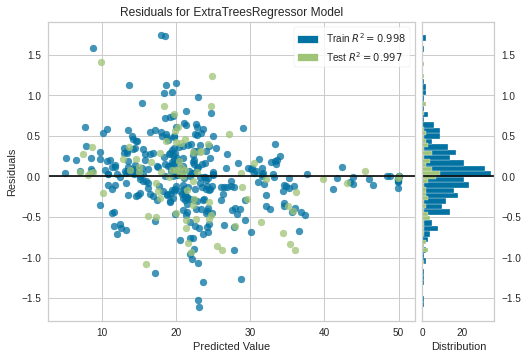

In [16]:
plot_model(final_model, plot='residuals')

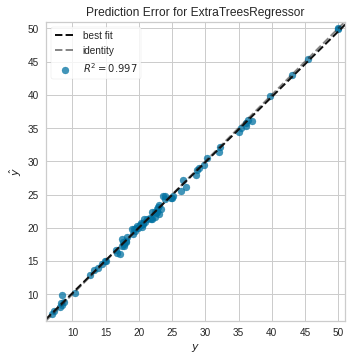

In [17]:
plot_model(final_model, plot='error')

### **結果の出力**

ファイナライズされたモデルを利用して、予測(prediction)結果を出力


In [18]:
# 結果の出力 (今回はsubmission対象でないので出力しない)

pred_test = predict_model(final_tuned_models[0], data=df_test)
pred_test[['Label']].to_csv('pred_test_label.csv', index=True, header=True)

### **アンサンブルもやってみる**

#### **Blend Models**

次の３ケースでブレンドを実施 
- 上位3のベースモデル
- 上位3のチューニング済みモデル
- 上位6のベースモデル

In [19]:
time_start = datetime.now(JST)
blended_top3_model = blend_models(top_models[0:3], optimize=target_metric, verbose=False)
elapse = (datetime.now(JST)-time_start).total_seconds()

brend_top3_models_score = pull()['Mean':'Mean'] # 学習結果の取得
print(f'\n## 上位3モデルのブレンド結果')
display(brend_top3_models_score)
print(f'\n## モデル:\n{blended_top3_model}')

model_score = pd.concat([pd.Series({'Desc': 'Brend', 'Model': 'Top3'}), 
                            brend_top3_models_score.iloc[0],
                            pd.Series({'Elapse': elapse})])
all_model_score = all_model_score.append(model_score, ignore_index=True)


## 上位3モデルのブレンド結果


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,1.9748,8.0062,2.7303,0.9004,0.124,0.1004



## モデル:
VotingRegressor(estimators=[('et',
                             ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                                 criterion='mse',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=-1,
                                                 oob_score=False,
                         

In [20]:
time_start = datetime.now(JST)
blended_top3_model = blend_models(tuned_models[0:3], optimize=target_metric, verbose=False)
elapse = (datetime.now(JST)-time_start).total_seconds()

brend_top3_models_score = pull() # 学習結果の取得
print(f'\n## チューニングされた上位3モデルのブレンド結果')
display(brend_top3_models_score['Mean':'Mean'])

model_score = pd.concat([pd.Series({'Desc': 'Brend_Tuned', 'Model': 'Top3'}), 
                            brend_top3_models_score.iloc[0],
                            pd.Series({'Elapse': elapse})])
all_model_score = all_model_score.append(model_score, ignore_index=True)


## チューニングされた上位3モデルのブレンド結果


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,1.8793,6.7583,2.528,0.9158,0.117,0.0954


In [21]:
time_start = datetime.now(JST)
blended_top6_model = blend_models(top_models[0:6], optimize=target_metric, verbose=False)
elapse = (datetime.now(JST)-time_start).total_seconds()

brend_top6_models_score = pull()['Mean':'Mean'] # 学習結果の取得
print(f'\n## 上位6モデルのブレンド結果')
display(brend_top6_models_score)

model_score = pd.concat([pd.Series({'Desc': 'Brend', 'Model': 'Top6'}), 
                            brend_top6_models_score.iloc[0],
                            pd.Series({'Elapse': elapse})])
all_model_score = all_model_score.append(model_score, ignore_index=True)


## 上位6モデルのブレンド結果


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,2.0421,8.5249,2.8281,0.8934,0.1259,0.1025


#### **Stack Models**

次の３ケースでスタック学習を実施
- 上位3のベースモデル+メタモデル:lr
- 上位3のチューニング済みモデル+メタモデル:lr
- 上位6のベースモデル+メタモデル:lr

In [22]:
time_start = datetime.now(JST)
lr = create_model('lr', verbose=False)
stacked_model = stack_models(top_models[0:3], meta_model=lr, optimize=target_metric, verbose=False)
elapse = (datetime.now(JST)-time_start).total_seconds()

stack_top3_model_score = pull()['Mean':'Mean'] # 学習結果の取得
print(f'\n## 上位3モデルのスタック結果')
display(stack_top3_model_score)

model_score = pd.concat([pd.Series({'Desc': 'Stacked', 'Model': 'Top3'}), 
                            stack_top3_model_score.iloc[0],
                            pd.Series({'Elapse': elapse})])
all_model_score = all_model_score.append(model_score, ignore_index=True)


## 上位3モデルのスタック結果


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,1.912,7.1512,2.5968,0.908,0.1195,0.0964


In [23]:
time_start = datetime.now(JST)
lr = create_model('lr', verbose=False)
stacked_model = stack_models(tuned_models[0:3], meta_model=lr, optimize=target_metric, verbose=False)
elapse = (datetime.now(JST)-time_start).total_seconds()

stack_top3_model_score = pull()['Mean':'Mean'] # 学習結果の取得
print(f'\n## 上位3チューニング済みモデルのスタック結果')
display(stack_top3_model_score)

model_score = pd.concat([pd.Series({'Desc': 'Stack_Tuned', 'Model': 'Top3'}), 
                            stack_top3_model_score.iloc[0],
                            pd.Series({'Elapse': elapse})])
all_model_score = all_model_score.append(model_score, ignore_index=True)


## 上位3チューニング済みモデルのスタック結果


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,1.9041,6.8991,2.5416,0.9119,0.1172,0.096


In [24]:
time_start = datetime.now(JST)
lr = create_model('lr', verbose=False)
stacked_model = stack_models(top_models[0:6], meta_model=lr, optimize=target_metric, verbose=False)
elapse = (datetime.now(JST)-time_start).total_seconds()

stack_top6_model_score = pull()['Mean':'Mean'] # 学習結果の取得
print(f'\n## 上位6モデルのスタック結果')
display(stack_top6_model_score)

model_score = pd.concat([pd.Series({'Desc': 'Stack', 'Model': 'Top6'}), 
                            stack_top6_model_score.iloc[0],
                            pd.Series({'Elapse': elapse})])
all_model_score = all_model_score.append(model_score, ignore_index=True)


## 上位6モデルのスタック結果


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,1.8934,7.1794,2.5928,0.9093,0.12,0.0961


### **これまでのモデルの学習結果を表示**

In [25]:
print(f'\n## これまでのモデルの結果 (metric:{target_metric})')
display(all_model_score.sort_values(target_metric, ascending=target_metric_ascending))


## これまでのモデルの結果 (metric:R2)


,Desc,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),Elapse
20,Stack_Tuned,Top3,1.9041,6.8991,2.5416,0.9119,0.1172,0.0960,NaN,131.3475
9,Tuned_iter300,catboost,1.9085,7.3919,2.6324,0.9097,0.1204,0.0959,NaN,3354.0284
21,Stack,Top6,1.8934,7.1794,2.5928,0.9093,0.1200,0.0961,NaN,320.8309
19,Stacked,Top3,1.9120,7.1512,2.5968,0.9080,0.1195,0.0964,NaN,248.6926
8,Tuned_iter300,et,1.9360,7.2976,2.6378,0.9072,0.1206,0.0985,NaN,3249.4244
10,Tuned_iter300,gbr,2.0195,7.5154,2.6721,0.9064,0.1263,0.1028,NaN,514.4731
17,Brend_Tuned,Top3,2.2929,10.2121,3.1956,0.9049,0.1428,0.1150,NaN,12.7170
0,Base,et,1.9093,7.5573,2.6672,0.9039,0.1207,0.0974,0.672,NaN
16,Brend,Top3,1.9748,8.0062,2.7303,0.9004,0.1240,0.1004,NaN,23.5602
1,Base,catboost,1.9639,8.2283,2.7698,0.9003,0.1234,0.0980,1.744,NaN


### **全体での最良のモデルを選択(automl)、表示**

In [26]:
best_model = automl(optimize='r2')
print(best_model)

VotingRegressor(estimators=[('et',
                             ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                                 criterion='mse', max_depth=11,
                                                 max_features=0.9076788877768341,
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=1.6210205664328739e-09,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=274, n_jobs=-1,
                                                 oob_...
                                                       max_leaf

### **Bestモデルをファイナライズしてテストデータで評価**

In [29]:
model_name = 'Best_Model'
print(f'\n### Model Name: {model_name}')
final_best_model = finalize_model(best_model)

pred_test = predict_model(final_best_model, data=df_test)
#display(pred_test)
r2   = r2_score(df_test[target_colname], pred_test["Label"])
rmse = math.sqrt(mean_absolute_error(df_test[target_colname], pred_test["Label"]))
print(f'\n### Model Name: {model_name}, Score R2: {r2:.5f}, RMSE: {rmse:.5f}\n')

model_score = pd.Series({'Desc': 'Final_Best', 'Model': model_name, 'RMSE': rmse, 'R2': r2})
all_final_model_score = all_final_model_score.append(model_score, ignore_index=True)

print(f'\n### 最初に分離したテストデータに対する予測結果 (metric:{target_metric})')
display(all_final_model_score.sort_values(target_metric, ascending=target_metric_ascending))



### Model Name: Best_Model

### Model Name: Best_Model, Score R2: 0.73998, RMSE: 1.62516


### 最初に分離したテストデータに対する予測結果 (metric:R2)


,Desc,Model,R2,RMSE
2,Final_Tuned,gbr,0.7406,1.6336
8,Final_Best,Best_Model,0.7400,1.6252
0,Final_Tuned,et,0.7359,1.6579
3,Final_Tuned,xgboost,0.7321,1.6458
1,Final_Tuned,catboost,0.7255,1.6401
5,Final_Tuned,lightgbm,0.7192,1.6615
4,Final_Tuned,rf,0.7071,1.6850
6,Final_Tuned,ada,0.6570,1.8410
7,Final_Tuned,lr,0.5892,1.9603
